# Customer Churn Prediction

In the highly competitive telecom industry, retaining customers is as important as acquiring new ones. When a customer cancels their service, i.e., customer churn, it directly impacts revenue and growth. This project uses a dataset of telecom customers in the United States, containing demographic details, subscription plans, and churn status, to uncover the main factors driving churn and to build a predictive model that helps the business proactively retain at-risk customers.

#### The Business Problem

Telecom companies face significant losses when customers leave. Understanding who is likely to churn enables targeted retention strategies, reducing costs and improving customer satisfaction. The goal of this project is to:

* Identify patterns in customer behavior that signal a higher risk of churn.

* Build a predictive model to flag at-risk customers.

* Provide actionable insights for business decision-makers.

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.io as pio
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


## Importing Libraries

We start by importing essential libraries for: 

* Data manipulation (Pandas, NumPy)

* Visualization (Seaborn, Matplotlib, Plotly)

* Modeling (scikit-learn)

Then we follow by loading the customer churn dataset into a pandas DataFrame. 

In [101]:
cust_churn = pd.read_excel('../data/CustomerChurn.xlsx')
cust_churn.head(3)

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## Data Cleaning

As we can see, the dataset contains 21 columns, including some of the following informations: 

* Contract: The contract type (Month-to-month, One year, etc.).

* Payment Method: How the customer makes payments (e.g., Bank transfer, Credit card).

* Monthly Charges: The amount the customer is billed monthly.

* Total Charges: Cumulative amount billed to the customer.

* Churn Label: Indicates whether the customer has churned (Yes/No).

In [102]:
cust_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LoyaltyID          7043 non-null   int64  
 1   Customer ID        7043 non-null   object 
 2   Senior Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure             7043 non-null   int64  
 6   Phone Service      7043 non-null   object 
 7   Multiple Lines     7043 non-null   object 
 8   Internet Service   7043 non-null   object 
 9   Online Security    7043 non-null   object 
 10  Online Backup      7043 non-null   object 
 11  Device Protection  7043 non-null   object 
 12  Tech Support       7043 non-null   object 
 13  Streaming TV       7043 non-null   object 
 14  Streaming Movies   7043 non-null   object 
 15  Contract           7043 non-null   object 
 16  Paperless Billing  7043 

We can use .info() to inspect data types and check for nulls. However, many columns are of type 'object', which could hide, for example, empty strings without spotting possible missing values. These are not detected as NaN by default, so we must explore further using the following step:

In [103]:
for col in cust_churn.columns:
    n_empty = (cust_churn[col].astype(str).str.strip() == '').sum()
    
    if n_empty != 0:
        print(f'{col}: {n_empty} empty strings')

Total Charges: 11 empty strings


This snippet returns the columns with missing values along with the count of missing entries in each. It allows us to have an idea of how to deal with the missing data.

In this case, there are only 11 empty entries out of 7043, which corresponds less than 0.2% of the missing data, so dropping them would be acceptable. Although we could fill these using the approximation 'TotalCharges' ≈ 'MonthlyCharges' × 'Tenure', we choose to drop the rows instead.

This decision simplifies the pipeline and avoids injecting assumptions, especially since 'TotalCharges' is highly correlated with other features.

In [104]:
pd.set_option('future.no_silent_downcasting', True)

cust_churn['Total Charges'] = cust_churn['Total Charges'].replace(r'^\s*$', np.nan, regex=True)
cust_churn['Total Charges'] = pd.to_numeric(cust_churn['Total Charges'])

cust_churn.dropna(subset=['Total Charges'], inplace=True)

Additionally, we will drop the 'LoyaltyID' and 'Customer ID' columns, as we will not use those informations to predict the model.

In [105]:
cust_churn.drop(['LoyaltyID','Customer ID'], axis = 1, inplace=True)
cust_churn.head(3)

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


## Feature engineering

Now, we will convert categorical variables such as 'Internet Service' and 'Contract' to dummy variables using `pd.get_dummies()`.

#### What are dummy variables?

Dummy variables are numeric variables created to represent categories in a dataset, as many machine learning algorithms and statistical models require input features to be numeric.

So, for each category in a categorical variable, a new binary (0 or 1) variable is created. For example, for a "Payment Method" variable with the following categories, we create four dummy variables which will take value 1 if the category is attended or 0 otherwise

* Electronic check → PaymentMethod_Electronic check (1 if Electronic check, else 0)

* Mailed check → PaymentMethod_Mailed check (1 if Mailed check, else 0)

* Bank transfer (automatic) → PaymentMethod_Bank transfer (automatic) (1 if Bank transfer, else 0)

* Credit card (automatic) → PaymentMethod_Credit card (automatic) (1 if Credit card, else 0)

However, to avoid a perfect correlation, called multicollinearity, usually one dummy variable is dropped and will be used as a reference category.

In [106]:
cust_churn['Payment Method'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [107]:
cust_churn['Online Backup'].unique()

array(['Yes', 'No', 'No internet service'], dtype=object)

Also, observe that features such as Online Backup, Streaming TV, Tech Support, and similar service-related columns often contain three values:

* 'Yes' → the customer is subscribed to the service

* 'No' → the customer is not subscribed

* 'No internet service' → the customer doesn’t have internet, so the service isn’t applicable

Although 'No internet service' is technically different from 'No', both indicate that the customer does not use the service, and for the purpose of churn prediction, what matters is whether the customer is using the service or not. 

So, by treating 'No internet service' as 'No', we simplify the feature and focus on whether the customer uses the service, which is more aligned with the business objective.

In [108]:
cols = ['Online Backup', 'Online Security', 'Tech Support', 'Device Protection', 'Streaming TV', 'Streaming Movies']

for col in cols:
    cust_churn[col] = cust_churn[col].replace({'No internet service': 'No'})

In [109]:
cols_to_dummify = [
    'Multiple Lines', 'Internet Service', 'Contract', 'Payment Method',
    'Online Security', 'Online Backup', 'Device Protection',
    'Tech Support', 'Streaming TV', 'Streaming Movies'
]

dummies_list = [
    pd.get_dummies(cust_churn[col], prefix=col.replace(' ', ''), drop_first=False).astype(int)
    for col in cols_to_dummify
]

cust_churn = pd.concat([cust_churn] + dummies_list, axis=1)

In [110]:
cust_churn.columns

Index(['Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'OnlineSecurity_No', 'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_Yes', 'StreamingTV_No',
       'StreamingTV_Yes', 'StreamingM

After creating the dummy variables, the columns bellow will be used as reference categories. 

These were intentionally selected to simplify the interpretation of the model results later on. By using these baseline categories, all other dummy variables represent differences relative to these groups, making the effects easier to understand.

Next, we replace the labels 'Yes' and 'No' to binary 1 and 0, respectively, so that the model can process these features as numeric inputs.


In [111]:
cust_churn.drop(['MultipleLines_No','InternetService_No','Contract_Month-to-month','PaymentMethod_Mailed check', 'OnlineSecurity_No', 'OnlineBackup_No', 'DeviceProtection_No',
    'TechSupport_No', 'StreamingTV_No', 'StreamingMovies_No'],axis=1,inplace=True)

cust_churn = cust_churn.replace({'Yes':1,'No':0})

cust_churn.head(5)

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,...,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
0,0,1,0,1,0,No phone service,DSL,0,1,0,...,0,0,0,1,0,1,0,0,0,0
1,0,0,0,34,1,0,DSL,1,0,1,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,2,1,0,DSL,1,1,0,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,45,0,No phone service,DSL,1,0,1,...,0,1,0,0,1,0,1,1,0,0
4,0,0,0,2,1,0,Fiber optic,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Although the categorical variables have already been encoded into numerical (dummy) variables, the original categorical columns are kept in the dataset at this stage. This is done to support exploratory data analysis and facilitate business-oriented insights, where categorical labels are often more interpretable.

These original columns will only be dropped before training the model, to ensure only numerical features are passed to the algorithm. However, for some analyses, such as the correlation heatmap, the categorical columns are removed earlier, since they are not suitable for correlation calculations.

## Exploratory Data Analysis (EDA)

We will begin with the analysis of the categorical variables by using `.describe(include='object')`. This results in a table containing:

* count: Total number of non-null values.

* unique: Number of unique values in the column.

* top: Most frequent value in the column.

* freq: Frequency of the most common value.

This method allows us to detect extreme values ​​or outliers that may affect the model, while also gives an idea of ​​the distribution of variables, helping with the choice of appropriate treatments, like normalization, transformation, etc.

In [112]:
cust_churn.describe(include='object')

,Senior Citizen,Partner,Dependents,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Churn
count,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032,7032
unique,2,2,2,2,3,3,2,2,2,2,2,2,3,2,4,2
top,0,0,0,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,0
freq,5890,3639,4933,6352,3385,3096,5017,4607,4614,4992,4329,4301,3875,4168,2365,5163


It shows that most of the customers have:

* No multiple lines

* Fiber optic as Internet Service

* Contract Month-to-month

* Electronic check as payment method

#### Statistical Measures

We can follow by showing the statistical measures, which help us get a better understanding of trends, spread, and symmetry of the data. It can be done by calculating:

* Mean: The average value of the data.

* Standard Deviation: A measure of the spread of the data.

* Min/Max: The smallest and largest values in the dataset.

* Percentiles: 25%, 50%, 75% (with 50% being the median).

In [113]:
cust_churn[cust_churn['Churn'] == 0].describe() # No churn

,Tenure,Monthly Charges,Total Charges,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
count,5163.00000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000,5163.000000
mean,37.65001,61.307408,2555.344141,0.098780,0.410033,0.379043,0.348441,0.252954,0.317064,0.248693,0.249661,0.250629,0.333140,0.368390,0.362774,0.335077,0.365873,0.370521
std,24.07694,31.094557,2329.456984,0.298395,0.491887,0.485196,0.476523,0.434747,0.465378,0.432297,0.432859,0.433417,0.471382,0.482415,0.480847,0.472063,0.481721,0.482991
min,1.00000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.00000,25.100000,577.825000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.00000,64.450000,1683.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.00000,88.475000,4264.125000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,72.00000,118.750000,8672.450000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [114]:
cust_churn[cust_churn['Churn'] == 0]['Monthly Charges'].describe() # No churn monthly charges

count    5163.000000
mean       61.307408
std        31.094557
min        18.250000
25%        25.100000
50%        64.450000
75%        88.475000
max       118.750000
Name: Monthly Charges, dtype: float64

In [115]:
cust_churn[cust_churn['Churn'] == 1].describe() # Churn

,Tenure,Monthly Charges,Total Charges,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
count,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000,1869.000000
mean,17.979133,74.441332,1531.796094,0.090958,0.454789,0.245586,0.693954,0.088818,0.025682,0.138042,0.124131,0.573034,0.157838,0.279829,0.291600,0.165864,0.435527,0.437667
std,19.531123,24.666053,1890.822994,0.287626,0.498085,0.430549,0.460972,0.284556,0.158228,0.345036,0.329819,0.494770,0.364687,0.449035,0.454621,0.372058,0.495959,0.496232
min,1.000000,18.850000,18.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,56.150000,134.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,79.650000,703.550000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,29.000000,94.200000,2331.300000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,72.000000,118.350000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [116]:
cust_churn[cust_churn['Churn'] == 1]['Monthly Charges'].describe() # Churn monthly charges

count    1869.000000
mean       74.441332
std        24.666053
min        18.850000
25%        56.150000
50%        79.650000
75%        94.200000
max       118.350000
Name: Monthly Charges, dtype: float64

#### Demographic Insights on Churned Customers

 **Tenure**, which represents the number of months a customer has been subscribed, is significantly **lower** for customers who **churned**, with a median of approximately 18 months compared to 38 months for those who stayed. This suggests that churn is more common among newer or short-term customers.

**Monthly Charges** is **higher** for customers who **churned**, with a mean of approximately 74 dollars compared to 61 dollars for those who stayed, which suggests a relation between churn and higher prices.

Approximately **25%** of customers who churned are **seniors citizens**, while the majority are not. The 75th percentile being 1 confirms that only the top 25% fall into the senior category.

Around **36%** of churned customers reported having a **partner**. However, at least 50% do not, which may suggest that customers without a partner are more likely to churn.

Only **17%** of churned customers have **dependents**. The fact that all percentiles (25%, 50%, and 75%) are 0 shows that **the vast majority of churners are single-person households** or without dependents.

This suggests that being a senior citizen, not having a partner, and not having dependents may be associated with a higher likelihood of churn. These customers may feel less tied to the service, or may be more sensitive to price, support, or value perception.

We illustrate bellow the customer churn amount and it's rate by seniors citizens.  

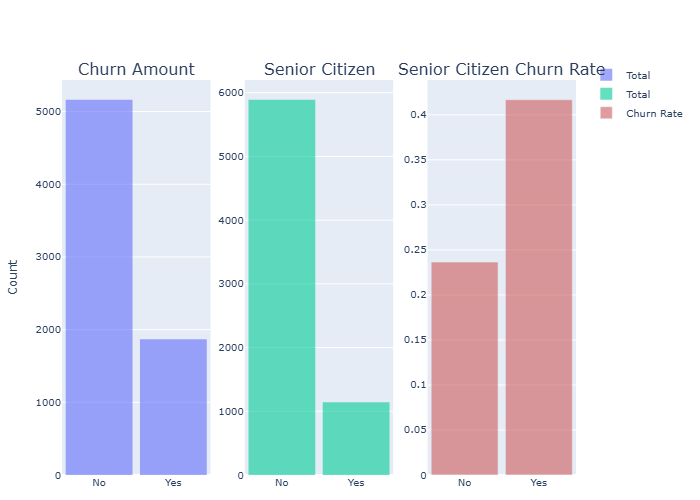

In [117]:
fig = make_subplots(rows=1, cols=3,subplot_titles=('Churn Amount', 'Senior Citizen', 'Senior Citizen Churn Rate'))

cust_churn = cust_churn.replace({1:'Yes',0:'No'})
fig.add_trace(go.Histogram(x=cust_churn['Churn'],nbinsx=60,name='Total',opacity=0.6), row=1, col=1)
fig.add_trace(go.Histogram(x=cust_churn[cust_churn['Churn']==1]['Churn'],nbinsx=60,name='Churn',opacity=0.6), row=1, col=1)

fig.add_trace(go.Histogram(x=cust_churn['Senior Citizen'],nbinsx=60,name='Total',opacity=0.6), row=1, col=2)
fig.add_trace(go.Histogram(x=cust_churn[cust_churn['Churn']==1]['Senior Citizen'],nbinsx=60,name='Churn',opacity=0.6), row=1, col=2)

cust_churn = cust_churn.replace({'Yes': 1, 'No': 0})
senior_citizen_churn = cust_churn.groupby('Senior Citizen')['Churn'].mean().reset_index()
senior_citizen_churn['Senior Citizen Label'] = senior_citizen_churn['Senior Citizen'].map({0: 'No', 1: 'Yes'})
fig.add_trace(go.Bar(x=senior_citizen_churn['Senior Citizen Label'],y=senior_citizen_churn['Churn'],name='Churn Rate',marker_color='indianred', opacity=0.6), row=1, col=3)

fig.update_layout(barmode='overlay',  bargap=0.1,width=1300,   height=500,margin=dict(l=20, r=20, t=80, b=20),yaxis_title='Count',font=dict(size=10),legend=dict(y=1.05, x=1.02))

pio.renderers.default = 'png'

fig.show()

It's important to observe that the number of churned customers is significantly smaller than the number of customers who remained with the service. This shows us an imbalanced class, which will be addressed later in the context of logistic regression.

#### Heatmap

Now, we will plot a heatmap in order to identify correlation between features and 'Churn', which is the target variable we want to predict. For this, we will drop the original categorical columns.

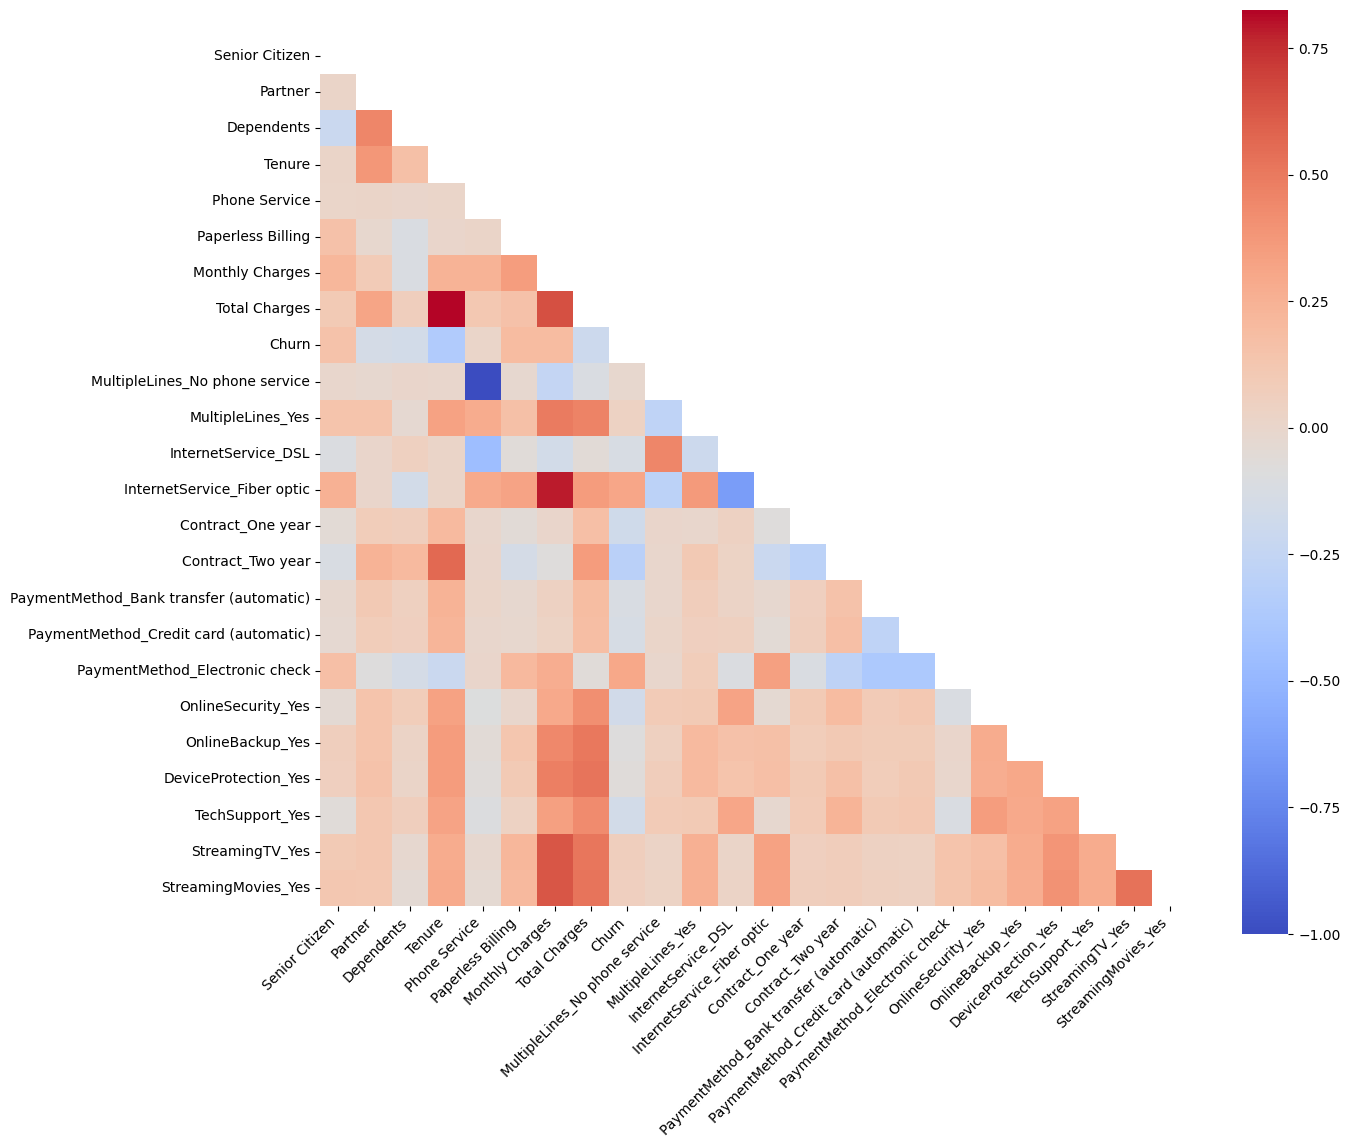

In [118]:
cust_churn_heatmap = cust_churn.drop(['Multiple Lines', 'Internet Service', 'Contract', 'Payment Method','Online Security', 'Online Backup', 'Device Protection',
    'Tech Support', 'Streaming TV', 'Streaming Movies'],axis=1)

plt.figure(figsize=(14,12))  

mask = np.triu(np.ones_like(cust_churn_heatmap.corr(), dtype=bool))
sns.heatmap(cust_churn_heatmap.corr(), annot=False, mask=mask, fmt=".2f", cmap="coolwarm", square=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

The heatmap shows some interesting informations:

* The 'Multiple Lines_No phone service' and 'Phone Service' demonstrates a **negative perfect correlation**, which tells us mantaining both features are redundant.

In [119]:
cust_churn.drop(['MultipleLines_No phone service'],axis=1,inplace=True) # dropping the redundant information to avoid multicolinearity

 The target variable 'Churn' shows the strongest **positive correlations** with the following features:
    
* InternetService_Fiber optic

* PaymentMethod_Electronic check

While shows the strongest **negative correlations** with the following features:

* TechSupport_Yes

* DeviceProtection_Yes

* OnlineSecurity_Yes
    
* OnlineBackup_Yes

It demonstrates that subscription to security, device protection or support services are related to decreased customer churn. Aditionally, customers with longer tenure, especially those under a two-year contract, tend to be more loyal and are less likely to churn.

In contrast, customers who use electronic check as a payment method tend to have higher churn rates.

These relationships can be visualized in the following Plotly graphs, which help illustrate the connection between customer behavior and churn.

#### Tenure and Contract vs Churn

The longer a customer stays with the company, the **less likely they are to churn**. This is evident from the 'Tenure' distribution.
Additionally, customers under the reference category 'Contract_Month-to-month' appear to have the highest churn rates, almost 43%, highlighting the lack of long-term commitment as a key churn factor.



In [120]:
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Tenure', 'Contract', 'Contract Churn Rate'))

fig.add_trace(go.Histogram(x=cust_churn['Tenure'],nbinsx=60,name='Total',opacity=0.6), row=1, col=1)
fig.add_trace(go.Histogram(x=cust_churn[cust_churn['Churn']==1]['Tenure'],nbinsx=60,name='Churn',opacity=0.6), row=1, col=1)

fig.add_trace(go.Histogram(x=cust_churn['Contract'],nbinsx=60,name='Total',opacity=0.6), row=1, col=2)
fig.add_trace(go.Histogram(x=cust_churn[cust_churn['Churn']==1]['Contract'],nbinsx=60,name='Churn',opacity=0.6), row=1, col=2)

contract_churn = cust_churn.groupby('Contract')['Churn'].mean().reset_index()

fig.add_trace(go.Bar(x=contract_churn['Contract'],y=contract_churn['Churn'],name='Churn Rate',marker_color='indianred', opacity=0.6), row=1, col=3)

fig.update_layout(
    barmode='overlay',  
    bargap=0.1,
    width=1500,   
    height=600,
    margin=dict(l=20, r=20, t=80, b=20),
    yaxis_title='Count',
    font=dict(size=10),
    legend=dict(y=1.05, x=1.02)
)

pio.renderers.default = 'plotly_mimetype'
fig.show()

#### Services Subscriptions vs Churn

The non subscription to services are correlated to higher customer churn.

In [121]:
cust_churn = cust_churn.replace({1:'Yes',0:'No'})

fig = make_subplots(
    rows=1, cols=4,
    subplot_titles=('Online Security','Tech Support', 'Device Protection', 'Online Backup'))

fig.add_trace(go.Histogram(x=cust_churn['Online Security'], opacity=0.6, name='Total'), row=1, col=1)
fig.add_trace(go.Histogram(x=cust_churn[cust_churn['Churn']=='Yes']['Online Security'], opacity=0.6, name='Churn'), row=1, col=1)

fig.add_trace(go.Histogram(x=cust_churn['Tech Support'], opacity=0.6, name='Total'), row=1, col=2)
fig.add_trace(go.Histogram(x=cust_churn[cust_churn['Churn']=='Yes']['Tech Support'], opacity=0.6, name='Churn'), row=1, col=2)

fig.add_trace(go.Histogram(x=cust_churn['Device Protection'], opacity=0.6, name='Total'), row=1, col=3)
fig.add_trace(go.Histogram(x=cust_churn[cust_churn['Churn']=='Yes']['Device Protection'], opacity=0.6, name='Churn'), row=1, col=3)

fig.add_trace(go.Histogram(x=cust_churn['Online Backup'], opacity=0.6, name='Total'), row=1, col=4)
fig.add_trace(go.Histogram(x=cust_churn[cust_churn['Churn']=='Yes']['Online Backup'], opacity=0.6, name='Churn'), row=1, col=4)

fig.update_layout(
    barmode='overlay',  
    bargap=0.1,
    width=1300,   
    height=600,
    margin=dict(l=20, r=20, t=80, b=20),
    yaxis_title='Count',
    font=dict(size=10),
    legend=dict(y=1.05, x=1.02)
)

pio.renderers.default = 'plotly_mimetype'
fig.show()


#### Internet Service and Payment Method vs Churn

As we have observed on the heatmap, 'Churn' also presented positive correlations with 'Internet Service' and 'Payment Method', specifically Fiber optic and Electronic check, respectively. 

In [122]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Payment Method', 'Payment Churn Rate'))

fig.add_trace(go.Histogram(x=cust_churn['Payment Method'], opacity=0.6, name='Total'), row=1, col=1)
fig.add_trace(go.Histogram(x=cust_churn[cust_churn['Churn']=='Yes']['Payment Method'], opacity=0.6, name='Churn'), row=1, col=1)

cust_churn['Churn'] = cust_churn['Churn'].map({'No': 0, 'Yes': 1})
payment_method_churn = cust_churn.groupby('Payment Method')['Churn'].mean().reset_index()
fig.add_trace(go.Bar(x=payment_method_churn['Payment Method'],y=payment_method_churn['Churn'],name='Churn Rate',marker_color='indianred', opacity=0.6), row=1, col=2)

fig.update_layout(barmode='overlay', bargap=0.1, width=1300, height=500, margin=dict(l=20, r=20, t=80, b=20), yaxis_title='Count', font=dict(size=10), legend=dict(y=1.05, x=1.02))

pio.renderers.default = 'plotly_mimetype'
fig.show()

In [123]:
fig = make_subplots( rows=1, cols=2, subplot_titles=('Internet Service', 'Internet Service Churn Rate'))

cust_churn = cust_churn.replace({1:'Yes',0:'No'})

fig.add_trace(go.Histogram(x=cust_churn[cust_churn['Internet Service']!='No']['Internet Service'], opacity=0.6, name='Total'), row=1, col=1)
fig.add_trace(go.Histogram(x=cust_churn[(cust_churn['Churn']=='Yes') & (cust_churn['Internet Service']!='No')]['Internet Service'], opacity=0.6, name='Churn'), row=1, col=1)

cust_churn['Churn'] = cust_churn['Churn'].map({'No': 0, 'Yes': 1})

internet_service_churn = cust_churn.groupby('Internet Service')['Churn'].mean().reset_index()
fig.add_trace(go.Bar(x=internet_service_churn[internet_service_churn['Internet Service']!= 'No']['Internet Service'],y=internet_service_churn['Churn'],name='Churn Rate',marker_color='indianred', opacity=0.6), row=1, col=2)

fig.update_layout( barmode='overlay', bargap=0.1, width=1300, height=500, margin=dict(l=20, r=20, t=80, b=20), yaxis_title='Count', font=dict(size=10), legend=dict(y=1.05, x=1.02))

pio.renderers.default = 'plotly_mimetype'
fig.show()

Customer churn associated with a specific payment method may suggest potential issues such as payment difficulties. 

Customers using electronic check may face greater payment friction and reduced flexibility, which can contribute to a higher likelihood of churn (representing 45% of churn amount), especially among those on month-to-month contracts, where the lack of long-term commitment and increased payment pressure make churn more probable. 

In [124]:
fig = go.Figure()

churned = cust_churn[cust_churn['Churn'] == 1]

payment_contract_churn = churned.groupby(['Payment Method', 'Contract']).size().reset_index(name='Count')
pivot = payment_contract_churn.pivot(index='Payment Method', columns='Contract', values='Count').fillna(0)

for contract_type in pivot.columns:
    fig.add_trace(go.Bar(x=pivot.index,y=pivot[contract_type],name=contract_type,opacity=0.6))

fig.update_layout( barmode='overlay', bargap=0.1, width=800, height=500, yaxis_title='Count', legend=dict(y=1.05, x=1.02), title='Payment-Contract Churn', title_x=0.5)

pio.renderers.default = 'plotly_mimetype'
fig.show()

We illustrate bellow the relation between 'Internet Service' and 'Payment Method' with respect to Monthly Changes, highlighting the differences between churned and non-churned customers.

In [125]:
cust_churn = cust_churn.replace({1:'Yes',0:'No'})

filtered_df = cust_churn[cust_churn['Internet Service'] != 'No']

fig = px.box(filtered_df, 
             x='Internet Service', 
             y='Monthly Charges', 
             color='Churn',
             title='Monthly Charges by Internet Service Type')

fig.update_layout(
    title_x=0.5,  
    width=800,   
    height=600,)

pio.renderers.default = 'plotly_mimetype'
fig.show()

In [126]:
fig = px.box(cust_churn, 
             x='Payment Method', 
             y='Monthly Charges', 
             color='Churn',
             title='Monthly Charges by Payment Method Type')

fig.update_layout(
    title_x=0.5,  
    width=800,   
    height=600,)

pio.renderers.default = 'plotly_mimetype'
fig.show()

Based on the boxplot 'Monthly Charges by Payment Method Type', we can see that the montlhy charges across different payment methods don't differ significantly (except by mailed check), which suggests that customers using Electronic check, are not churning because of high prices, but maybe for other reasons associated with payment difficulties or lack of flexibility, characteristic of this payment method.

In addition, from the boxplot 'Monthly Charges by Internet Service Type', we can observe that churned customers tend to pay less than those who remained with the service in each category, also suggesting customers are not churning because of high prices, but for other reasons that may be associated with service quality.

#### What have we discovered so far?

Customer churn is mostly related to:

* Newer or short-term customers

* No partner or no dependents

* Month-to-month contract type

* Non subscription to security, device or support services

* Electronic check as payment method associated with month-to-month contract type

## Logistic Regression Model

Now it's time to construct a logistic regression model to predict customer churn. The process begins with defining the features (X) and target (y).

We select the relevant predictor variables (independent variables) to form our feature set X and 'Churn' as the target variable y. 

In [127]:
X = cust_churn_heatmap.drop('Churn',axis=1)
y = cust_churn_heatmap['Churn']
y = y.astype('int64')

It's important to remember that we are dealing with a classification problem involving imbalanced classes. In most datasets, the number of customers who did not churn significantly outweighs the number of customers who did churn. 

This imbalance can lead to biased models, where the classifier favors the majority class (non-churners) and performs poorly at identifying the minority class (churners), which is the group we're most interested in. For this reason, we can use the `class_weight=balanced` parameter in scikit-learn's.

It tells the model to automatically adjust weights inversely proportional to class frequencies in the input data, which gives more importance to the minority class during training, helping the model learn from those examples more effectively.

#### Lasso (L1) and Ridge (L2)

When training a logistic regression model, it's also important to apply regularization to avoid overfitting, especially in cases when many features are involved. We will be choosing between Lasso and Ridge, to see which one performs better in this cenario.

* L1 Regularization (Lasso)

    * Adds a penalty equal to the absolute value of the coefficients.

    * Can shrink some coefficients to exactly zero, which effectively performs feature selection.

    * Useful when we suspect that only a subset of the features is truly important.

* L2 Regularization (Ridge)
    
    * Adds a penalty equal to the squared magnitude of the coefficients.

    * Shrinks coefficients smoothly but does not reduce them to zero.

    * Preferred when all features are expected to have some effect and we want to prevent overfitting without feature elimination.

For this evaluation, we will be using ROC AUC (Receiver Operating Characteristic – Area Under the Curve) as our main metric.

#### ROC AUC

The ROC curve is a graphical representation of the model’s performance across all classification thresholds, and the AUC (Area Under the Curve) summarizes this curve into a single value between 0.5 and 1.0. The higher the AUC, the better the model is at distinguishing between churners and non-churners.



In [128]:
# L1
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, class_weight='balanced')
scores_l1 = cross_val_score(model_l1, X, y, cv=5, scoring='roc_auc')

# L2
model_l2 = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, class_weight='balanced')
scores_l2 = cross_val_score(model_l2, X, y, cv=5, scoring='roc_auc')

print("AUC L1:", scores_l1.mean())
print("AUC L2:", scores_l2.mean())

AUC L1: 0.8452506729322782
AUC L2: 0.8449954012883731


After evaluating both models using cross-validation with the ROC AUC metric, we obtained the following results:

* AUC L1 (Lasso): 0.8452

* AUC L2 (Ridge): 0.8449

As we can observe, L1 regularization performs slightly better than L2 in this cenario. Although the difference is minimal, L1 also offers the added benefit of feature selection by shrinking some coefficients to zero.

For these reasons, we will proceed with the L1-regularized logistic regression model for our final analysis.

#### Splitting the dataset and Training the model

Now, we follow by splitting the dataset into training and test sets

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=1.0,class_weight='balanced')
log_model_l1.fit(X_train,y_train)

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


#### Evaluating the model

After training, we use the model to predict the outcomes for the test data.

In [130]:
y_pred = log_model_l1.predict(X_test)

print(classification_report(y_pred=y_pred, y_true= y_test))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1549
           1       0.51      0.80      0.62       561

    accuracy                           0.74      2110
   macro avg       0.71      0.76      0.71      2110
weighted avg       0.80      0.74      0.75      2110



 This leads to metrics such as:

* Confusion matrix: compares the model’s predicted labels with the actual labels to show how many predictions were correct and where the model made mistakes. It takes this form:

|               | Predicted: No       | Predicted: Yes      |
|---------------|---------------------|---------------------|
| Actual: No    | True Negative (TN)   | False Positive (FP)  |
| Actual: Yes   | False Negative (FN)  | True Positive (TP)   |



* Accuracy: provides the proportion of correctly classified instances → (TP+TN)/Total

* Precision: gives the accuracy of positive predictions → TP/(TP+FP)

* Recall: measures the proportion of correctly predicted positive instances among all actual positive instances → TP/(TP+FN)

* F1 Score: harmonic mean of precision and recall → 2*(Precision*Recall)/(Precision+Recall)

#### What does this mean exactly?

Let's observe the confusion matrix bellow

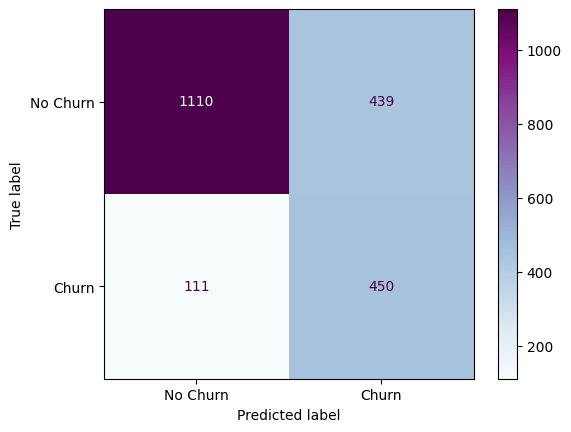

In [131]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["No Churn", "Churn"]).plot(cmap='BuPu')

The confusion matrix above takes the form:

|                      | Predicted: No Churn      | Predicted: Churn         |
| -------------------- | ------------------------ | ------------------------ |
| **Actual: No Churn** | 1109 (True Negative, TN) | 440 (False Positive, FP) |
| **Actual: Churn**    | 111 (False Negative, FN) | 450 (True Positive, TP)  |


* True Negatives (1109) shows that the model correctly predicted "No Churn" for 1109 customers who indeed did not churn.

* False Positives (440) shows that the model predicted "Churn" for 440 customers who actually stayed (no churn). These are false alarms.

* False Negatives (111) shows that the model predicted "No Churn" for 111 customers who actually churned. These are missed churners.

* True Positives (450) shows that the model correctly predicted "Churn" for 450 customers who did churn.

In customer churn prediction, one of the most important objectives is to minimize false negatives (FN), even if it results in an increase in false positives (FP). This is because false negatives represent customers who churn without receiving any retention efforts, leading directly to lost revenue.

#### Which ones of these metrics to look for?

Accuracy, although provides the proportion of correctly classified instances, it does not suit well imbalanced datasets like customer churn prediction. In this case, precision, recall and F1-score are the most appropriate.

#### Interpretation

* Precision: When the model predicts churn, it is right about 51% of the time.

* Recall: The model correctly identifies 80% of all customers who actually churned.

* F1-score: The model balances precision and recall with 62%.

This means that the model is better at identifying churners (80% recall) than it is at being precise when it predicts churn (only 51% precision), so many customers predicted to churn would actually stay.

So, depending on business goals, if catching as many churners as possible is key, this model is fairly good. However, if reducing false positives is important (to avoid unnecessary interventions), the model may need improvement.

#### How each feature impacts customer churn?

After training the logistic regression model, it's important to analyze the model coefficients to understand how each feature contributes to the prediction of churn.

In [132]:
coefficients = log_model_l1.coef_[0]

features_names = X_train.columns

df_coef = pd.DataFrame({'Feature': features_names,'Coefficient': coefficients})

df_coef['Relevance'] = df_coef['Coefficient']
df_coef = df_coef.sort_values(by='Relevance', ascending=False)

df_coef[['Feature', 'Coefficient']]


,Feature,Coefficient
11,InternetService_Fiber optic,0.976547
10,InternetService_DSL,0.475511
16,PaymentMethod_Electronic check,0.356003
8,MultipleLines_No phone service,0.237706
0,Senior Citizen,0.229429
5,Paperless Billing,0.177551
1,Partner,0.127381
21,StreamingTV_Yes,0.114623
14,PaymentMethod_Bank transfer (automatic),0.109121
22,StreamingMovies_Yes,0.108303


These coefficients tell us the direction and strength of the relationship between each feature and the probability of churn:

* A positive coefficient increases the likelihood of churn.

* A negative coefficient decreases the likelihood of churn.

* A coefficient of zero means the feature was not relevant.

From the dataframe above, we observe that the top 5 features that increases churn are customers who: 

| Feature                                         | Coefficient | Interpretation                                                               |
| ----------------------------------------------- | ----------- | ---------------------------------------------------------------------------- |
| InternetService_Fiber optic                   | 1.20      | Fiber users are much more likely to churn compared to those without internet |
| InternetService_DSL                           | 0.59        | DSL users also have increased risk                             |
| PaymentMethod_Electronic check                | 0.35        | Highest churn among payment methods                                          |
| MultipleLines_No phone service                | 0.24        | Customers without phone service churn more                                   |
| Senior Citizen                                | 0.23        | Older customers tend to churn more                                           |

On the other hand:

| Feature                                    | Coefficient                  | Interpretation                                                   |
| ------------------------------------------ | ---------------------------- | ---------------------------------------------------------------- |
| Contract_Two year                        | -1.49                    | Customers on 2-year contracts are less likely to churn            |
| Contract_One year                        | -0.86                    | Annual contracts decreases customer churn           |
| OnlineSecurity_Yes                       | -0.42                        | Users with online security are less likely to churn              |
| Phone Service                            | -0.39                        | Having phone service is associated with lower churn              |
| TechSupport_Yes                          | -0.38                        | Technical support contributes to retention                       |
| Dependents                               | -0.24                        | Customers with dependents churn less                             |




## Final Analysis: Marketing Strategy

**1 - Retain Fiber optic and DSL users**

* Investigate service dissatisfaction such as price and service quality.

* Offer loyalty bonuses or special renewal offers.

* Consider bundling services, for example, security or support for fiber users.

**2 - Promote Long-Term Contracts**

* Make long-term contracts more appealing.

* Discounts for contract upgrades.

* Loyalty points and/or early renewal bonuses.

**3 - Offer Helpful Extra Services to Reduce Churn**

* Offer free trial services to customers who are at risk of leaving.

* Create special bundles that include one or more of these extras.

* Promote them as value-adding features during sign-up, upgrades, or billing time.

**4 - Watch Out for Risky Payment Types**

* Consider campaigns to encourage switching to auto-pay via credit card or bank transfer.

**5 - Targeted Engagement for Senior Citizens**

* Offer simplified interfaces, human-assisted support.

* Discounted or customizable plans for older customers.